In [4]:

#Try to use bm3d
#!pip install pydicom
import matplotlib.pyplot as plt
import pydicom
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from importlib import reload
from scipy import ndimage as nd
from skimage.metrics import peak_signal_noise_ratio
from skimage import img_as_float
from skimage import io

from build_dct_unitary_dictionary import build_dct_unitary_dictionary

from im2col import im2col
from col2im import col2im
from compute_psnr import compute_psnr

#CCH 20200520 widthen display output
np.set_printoptions(formatter={'float': lambda x: " {0:7.3f}".format(x)})


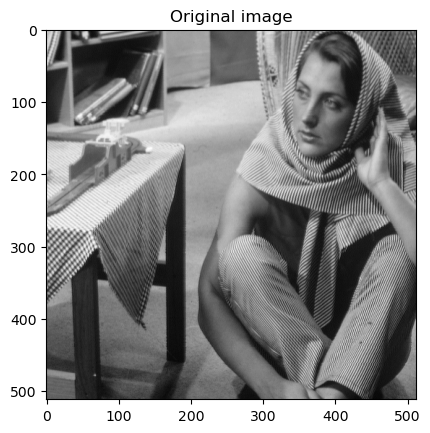

In [5]:
# Read an image
im = np.array(Image.open('barbara.png'))
#im = img_as_float(im)
# im = np.array(Image.open('misc\\brain4.jpg'))

# Show the image
plt.figure(0)
plt.imshow(im,'gray') 
plt.title('Original image')
plt.show()

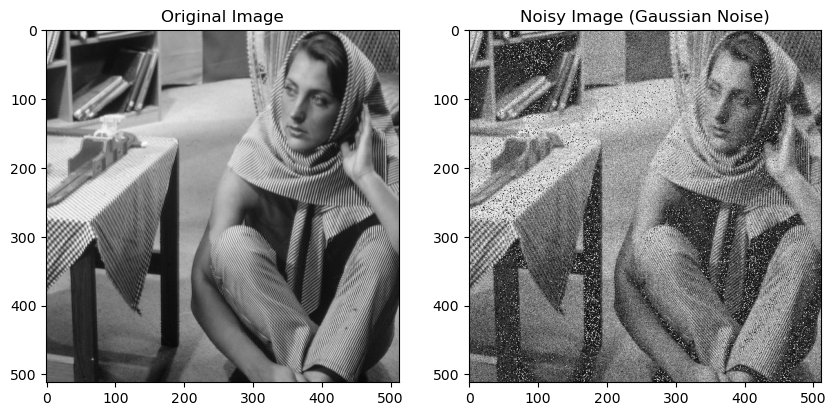

In [6]:
# Read an image
im = np.array(Image.open('barbara.png'))


# Parameters for Gaussian noise
mean = 0
stddev = 25  # You can adjust this to control the amount of noise

# Generate Gaussian noise with the same shape as the image
noise = np.random.normal(mean, stddev, im.shape).astype(np.uint8)

# Add the noise to the image
noisy_image = np.clip(im + noise, 0, 255).astype(np.uint8)

# Show the original and noisy images
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(im, cmap='gray')
plt.title('Original Image')

# Noisy image
plt.subplot(1, 2, 2)
plt.imshow(noisy_image, cmap='gray')
plt.title('Noisy Image (Gaussian Noise)')

plt.show()

In [7]:
print(noisy_image)

[[184 245 200 ...  92 102 142]
 [150 199 213 ...  99  73  77]
 [202 196 207 ...  85 127 151]
 ...
 [ 99  82  97 ... 117 142  65]
 [107  50  79 ...  99  91  86]
 [112 133 123 ... 120  79 131]]


In [8]:
#turn into float for skitimage

noisy_image = img_as_float(noisy_image)
print(noisy_image.shape)
print(im.shape)


(512, 512)
(512, 512)


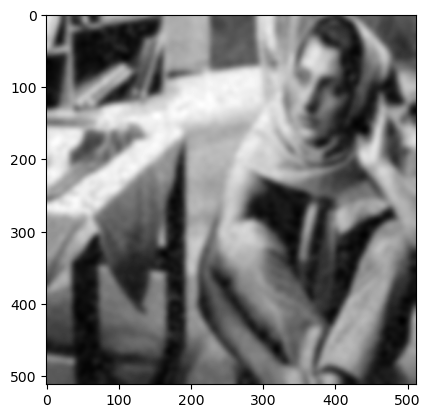

In [9]:
#gaussian filter
#Higher the sigma better denoising typically
gaussian_img = nd.gaussian_filter(noisy_image,sigma=4)
#its a bit blurry, but denoisede
plt.imshow(gaussian_img, cmap='gray')

In [10]:
noise_psnr= peak_signal_noise_ratio(im,noisy_image)
gaussian_cleaned_psnr = peak_signal_noise_ratio(im,gaussian_img)
print("PSNR noisy_image = " , noise_psnr)
print("PSNR of cleaned image = " , gaussian_cleaned_psnr)




PSNR noisy_image =  5.921108481802296
PSNR of cleaned image =  5.920079713899423


C:\Users\gyard\AppData\Local\Temp\ipykernel_6352\3569355622.py:1: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  noise_psnr= peak_signal_noise_ratio(im,noisy_image)
C:\Users\gyard\AppData\Local\Temp\ipykernel_6352\3569355622.py:2: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  gaussian_cleaned_psnr = peak_signal_noise_ratio(im,gaussian_img)


In [11]:
#Bilateral filter (very slow!)

from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,denoise_wavelet,estimate_sigma)
denoise_bilateral = denoise_bilateral(noisy_image,sigma_spatial=1)

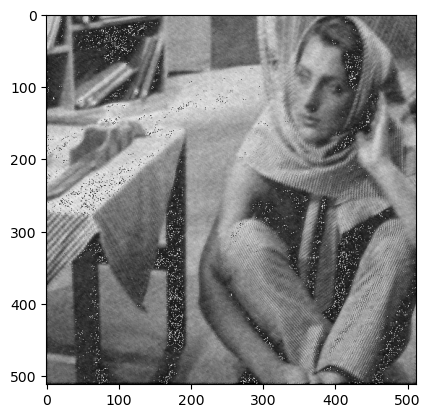

In [12]:
plt.imshow(denoise_bilateral, cmap='gray')

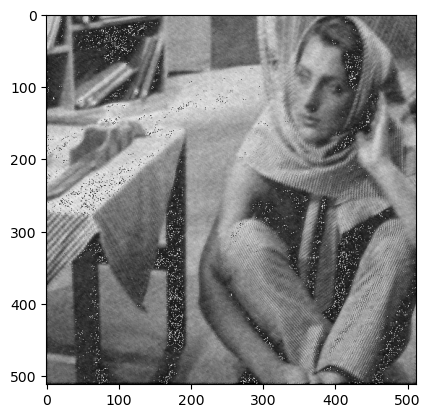

In [13]:
#Denoise_TV
denoise_tv= denoise_tv_chambolle(noisy_image,weight=0.3)
plt.imshow(denoise_bilateral, cmap='gray')
# plt.imshow(noisy_image, cmap='gray')
# plt.title('Noisy Image (Gaussian Noise)')

C:\Users\gyard\AppData\Local\Temp\ipykernel_6352\385578102.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


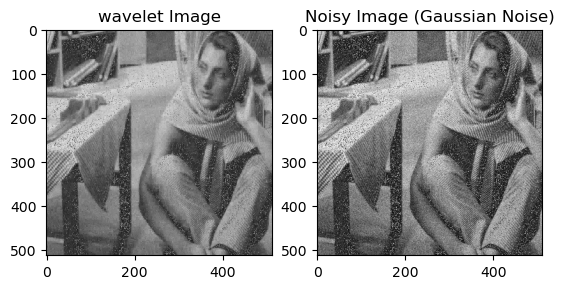

In [14]:
#Denoise wavelet

wavlet_smoothed = denoise_wavelet(noisy_image,method='BayesShrink',mode='soft')
plt.imshow(wavlet_smoothed, cmap='gray')

# plt.imshow(noisy_image, cmap='gray')
# plt.title('Noisy Image (Gaussian Noise)')

# Original image
plt.subplot(1, 2, 1)
plt.imshow(wavlet_smoothed, cmap='gray')
plt.title('wavelet Image')

# Noisy image
plt.subplot(1, 2, 2)
plt.imshow(noisy_image, cmap='gray')
plt.title('Noisy Image (Gaussian Noise)')

plt.show()


### MORE PROMISING FILTERS ( I HOPE )

In [17]:
from medpy.filter.smoothing import anisotropic_diffusion
import cv2
from skimage import io

im= img_as_float(im)

#anisotropic diffusion

img_aniso_filtered = anisotropic_diffusion(noisy_image,niter=50, gamma=0.2,option=2)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

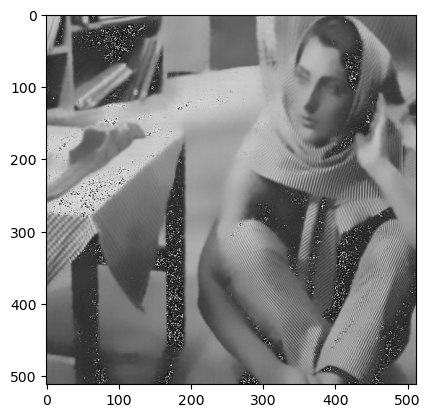

In [18]:
#NLM (non local means)

from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage import img_as_ubyte,img_as_float

sigma_est = np.mean(estimate_sigma(noisy_image))

NLM_skimg_denoise_img = denoise_nl_means(noisy_image, h= 1.05*sigma_est,fast_mode=True,patch_size=6)
plt.imshow(NLM_skimg_denoise_img, cmap='gray')

In [19]:
#CV2 nlm (do not convert to float)

NLM_CV2= cv2.fastNlMeansDenoising(noisy_image,True,3,7,21)
plt.imshow(NLM_CV2, cmap='gray')

error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\photo\src\denoising.cpp:142: error: (-5:Bad argument) Unsupported depth! Only CV_8U is supported for NORM_L2 in function 'cv::fastNlMeansDenoising'


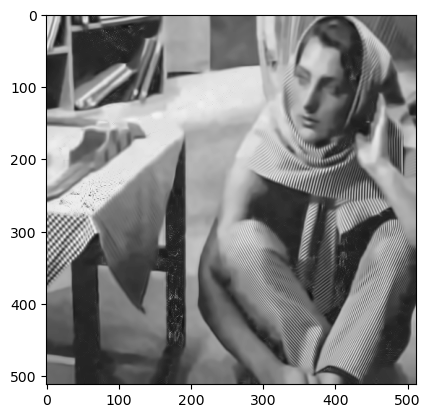

In [26]:
#Block Matching 3d filtering BM3D (needs to be float)
import bm3d 

BM3D_denoised= bm3d.bm3d(noisy_image,sigma_psd=0.2,stage_arg=bm3d.BM3DStages.ALL_STAGES)

plt.imshow(BM3D_denoised, cmap='gray')